# Demonstration notebook for DensityFieldTools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DensityFieldTools import DensityField3D, PkX

In [2]:
BoxSize = 1000. #Mpc/h
kF = 2*np.pi/BoxSize #h/Mpc
grid = 256

## Load an example density field

In [3]:
help(DensityField3D)

Help on class DensityField3D in module DensityFieldTools.DensityFieldTools:

class DensityField3D(builtins.object)
 |  DensityField3D(BoxSize, grid, delta_r=None, delta_c=None, n_threads=1, FFTW_WISDOM=False, r_dtype=<class 'numpy.float32'>)
 |  
 |  Class for manipulating three-dimensional density fields and measuring power spectra and bispectra.
 |  
 |  Parameters
 |  ----------
 |  BoxSize : float
 |      Size of the periodic box in Mpc/h units.
 |  grid : int
 |      Number of grid points per dimension.
 |  delta_r : ndarray, optional
 |      Real-space density field to load and FFT. Shape must match the grid.
 |  delta_c : ndarray, optional
 |      Complex Fourier-space density field to load and inverse FFT. Shape must match the grid.
 |  n_threads : int, optional
 |      Number of threads to use for parallelization.
 |  FFTW_WISDOM : bool, optional
 |      Whether to use precomputed FFTW wisdom.
 |  r_dtype : str or np.dtype, optional
 |      Data type for the density field in r

In [4]:
field = DensityField3D(BoxSize,grid,n_threads=1,FFTW_WISDOM=True)
field.Load_r2c(np.load(f"df_m_256_PCS_z=0.npy"),MAS='PCS')

Computing FFT Wisdom and Saving to pyFFTW_3D_grid256_dtypefloat32_threads1.npy done!


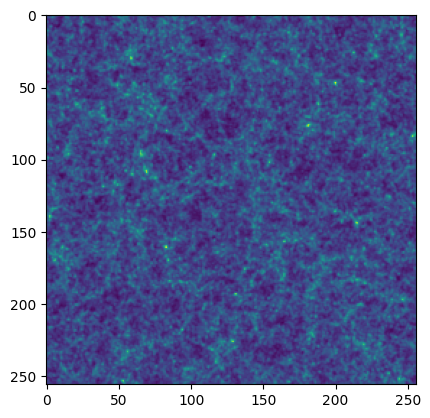

In [5]:
plt.imshow(field.r_delta.mean(2))
plt.show()

## Compute the power spectrum

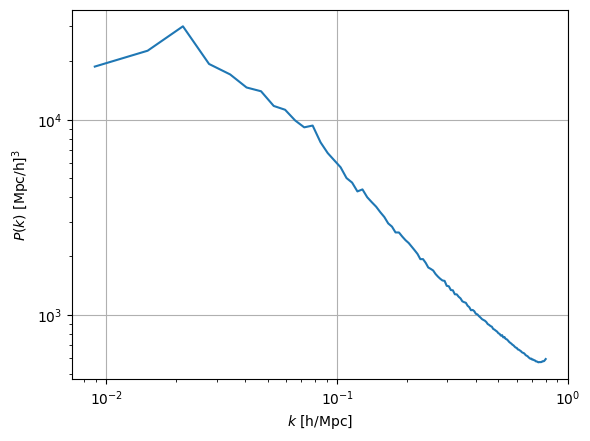

In [6]:
Pks = field.Pk()
plt.loglog(Pks[:,0],Pks[:,1])

plt.ylabel("$P(k)$ [Mpc/h]$^3$")
plt.xlabel("$k$ [h/Mpc]")
plt.grid()
plt.show()

## Compute the bispectrum for a desired binning

In [7]:
help(DensityField3D.Bk)

Help on function Bk in module DensityFieldTools.DensityFieldTools:

Bk(self, fc, dk, NBmax, triangle_type='All', verbose=False)
    Computes binned bispectrum of field for given binning and triangles
    
    Parameters:
    -----------
    fc: float
        Center of first bin in units of the fundamental mode.
    dk: float
        Width of the bin in units of the fundamental mode.
    NBmax: int
        Total number of momentum bins such that bins are given by kf*[(fc + i)±dk/2 for i in range(NBmax)].
    triangle_type: str, optional (default='All')
        Type of triangles to include in the bispectrum calculation. 
        Options: 'All' (include all shapes of triangles), 'Squeezed' (only triangles k_1 > k_2 = k_3), 
        'Equilateral' (include only triangles k_1 = k_2 = k_3).
    verbose: bool, optional (default=False)
        If True, print progress statements.
    
    Returns:
    --------
    result: numpy.ndarray
        An array of shape (len(counts['bin_centers']),8) con

In [8]:
%time BBB = field.Bk(3,3,27,triangle_type='All',verbose=True)

Considering 2276 Triangle Configurations (All)
Creating Grids for Counts...


100%|██████████| 27/27 [00:03<00:00,  7.94it/s]


Computing Powerspectrum Counts... 

100%|██████████| 27/27 [00:00<00:00, 49.57it/s]


Computing Triangle Counts... 

100%|██████████| 2276/2276 [01:06<00:00, 34.34it/s]


Saved Triangle Counts to FFTest3D_BkCounts_LBox1000.0_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy
Creating Grids for Measurements...


100%|██████████| 27/27 [00:03<00:00,  7.39it/s]


Computing Powerspectrum... 

100%|██████████| 27/27 [00:00<00:00, 54.80it/s]


Computing Bispectrum... 

100%|██████████| 2276/2276 [01:07<00:00, 33.73it/s]

CPU times: user 1min 54s, sys: 30.6 s, total: 2min 24s
Wall time: 2min 22s


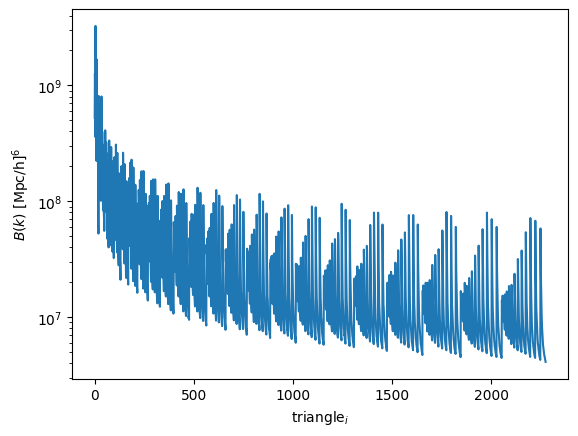

In [9]:
plt.semilogy(BBB[:,-2])
plt.ylabel("$B(k)$ [Mpc/h]$^6$")
plt.xlabel("triangle$_i$")
plt.show()

### The bispectrum estimator also automatically computes the power spectrum for the chosen binning, to facilitate e.g. shot-noise subtraction

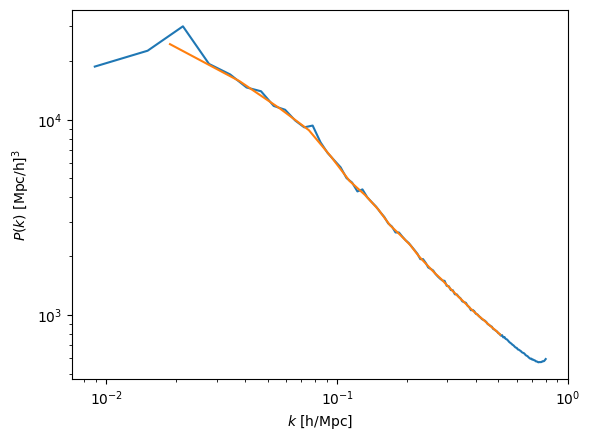

In [10]:
plt.loglog(Pks[:,0],Pks[:,1])
plt.loglog(np.unique(BBB[:,0])*kF,np.unique(BBB[:,3])[::-1])
plt.ylabel("$P(k)$ [Mpc/h]$^3$")
plt.xlabel("$k$ [h/Mpc]")
plt.show()

## The computation can also be done in parallel with substantial speed-ups

In [11]:
field = DensityField3D(BoxSize,grid,n_threads=8,FFTW_WISDOM=True)
field.Load_r2c(np.load(f"df_m_256_PCS_z=0.npy"),MAS='PCS')
%time BBB = field.Bk(3,3,27,triangle_type='All',verbose=True)

Computing FFT Wisdom and Saving to pyFFTW_3D_grid256_dtypefloat32_threads8.npy done!
Loading Counts from FFTest3D_BkCounts_LBox1000.0_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy
Considering 2276 Triangle Configurations (All)
Creating Grids for Measurements...


100%|██████████| 27/27 [00:01<00:00, 14.19it/s]


Computing Powerspectrum... 

100%|██████████| 27/27 [00:00<00:00, 335.62it/s]


Computing Bispectrum... 

100%|██████████| 2276/2276 [00:13<00:00, 162.81it/s]

CPU times: user 1min 23s, sys: 29.2 s, total: 1min 52s
Wall time: 16.3 s


## Finally, we also provide a quick way to measure (cross-)power spectra directly from density fields

CPU times: user 1.52 s, sys: 159 ms, total: 1.68 s
Wall time: 1.68 s
CPU times: user 3.73 s, sys: 277 ms, total: 4.01 s
Wall time: 4.02 s


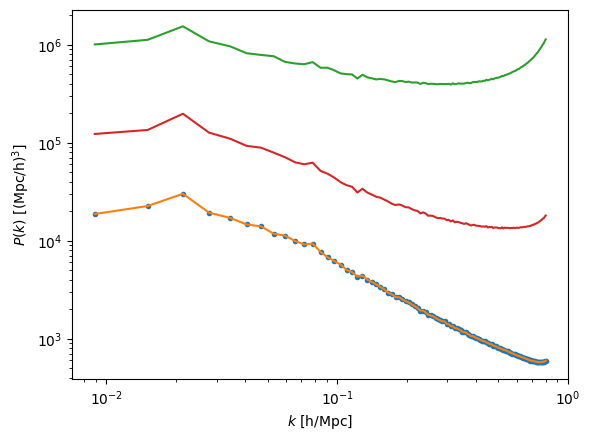

In [12]:
%time Pself = PkX(field.r_delta,1000.,MAS=['PCS'])
%time Pcross = PkX(field.r_delta,1000.,field.r_delta**2.,MAS=["PCS","PCS"])

plt.loglog(Pself[:,0],Pself[:,1],".")
plt.loglog(Pcross[:,0],Pcross[:,1])
plt.loglog(Pcross[:,0],Pcross[:,2])
plt.loglog(Pcross[:,0],Pcross[:,3])
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$P(k)$ [(Mpc/h)$^3$]")
plt.show()